Using device: cuda
L shape: torch.Size([10000, 10000])


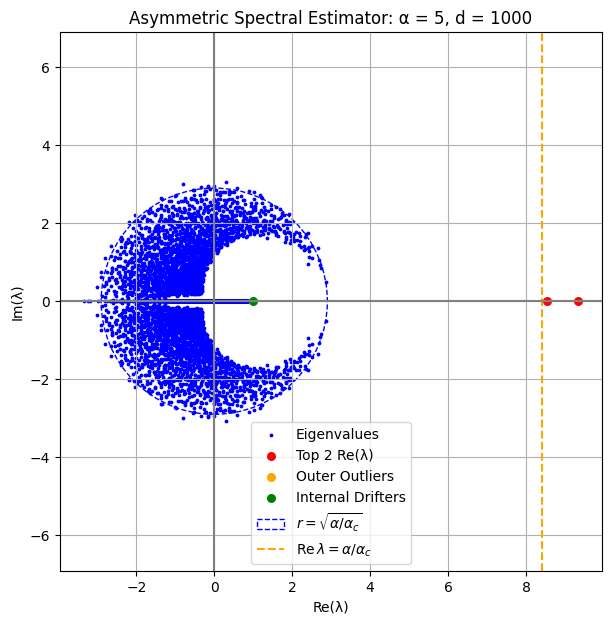


[Method 3: Single Eigenvector Alignment Scores]
  Eigenvalue  Index  Alignment Score
0     Green1   3814         0.550593
1       Red1      0         0.467812
2       Red2      1         0.450283

[Method 4: Eigenvector Pair Alignment Scores]
          Pair         Eigenvalue1         Eigenvalue2  Alignment Score
0  Green1-Red1  1.004545+0.000000j  9.322962+0.000000j         0.722492
2    Red1-Red2  9.322962+0.000000j  8.530980+0.000000j         0.649308
1  Green1-Red2  1.004545+0.000000j  8.530980+0.000000j         0.563182


/tmp/ipykernel_259496/1809887387.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


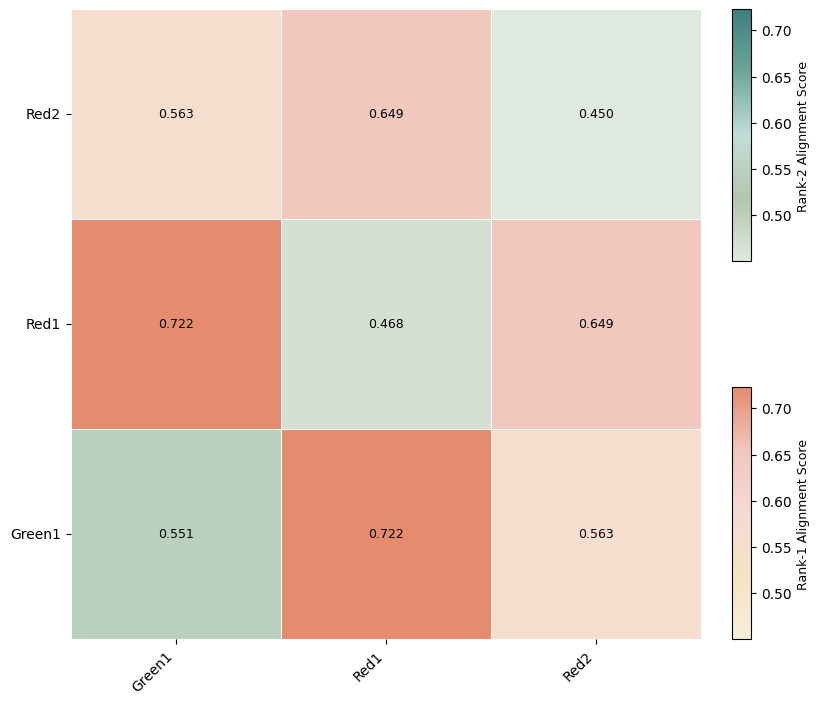

In [5]:
# asymmetric_spectral_estimator_updated.py

import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import kv as besselk
from scipy.linalg import qr
from numpy.linalg import norm
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ====================== 设置随机种子与设备 ======================
def set_seed(seed=4):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== 参数设置与数据生成 ======================
n, p = 5000, 2
alpha = 5
alpha_c = 0.59375
d = int(n / alpha)
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]

# ====================== 构造 G(y) 与谱矩阵 L ======================
y_np = y.detach().cpu().numpy()
abs_y = np.abs(y_np)
K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_np
G_y_np[:, 1, 0] = y_np
G_y = torch.tensor(G_y_np, device=device)

XXT = X @ X.T
XXT.fill_diagonal_(0.0)
L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}")

# ====================== 特征值与特征向量计算 ======================
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

# ====================== 特征值分类 ======================
R = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

outside = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in outside if z not in red_vals]
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:1]

green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals)]
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals)]
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# ====================== 谱图绘制 ======================
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=3, color='blue', label='Eigenvalues')
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color='red', s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color='orange', s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color='green', s=30, label="Internal Drifters")
circle = plt.Circle((0, 0), R, color='blue', fill=False, linestyle='--', label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--', label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


# ====================== 评估函数（方法3与4） ======================
import numpy as np
import pandas as pd
from scipy.linalg import qr
from numpy.linalg import norm

def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

def map_multiple_eigvecs_to_2d(eigvecs_np, eigvals_np, selected_eigvals, X, W_star, eigval_to_label, p=2):
    """
    映射多个非对称谱估计器的特征向量到 2d 空间，计算每个单点的对齐度，并附带标签显示。

    参数:
        eigvecs_np: ndarray, shape (n*p, n*p) — 所有特征向量矩阵
        eigvals_np: ndarray, shape (n*p,) — 所有特征值列表
        selected_eigvals: list — 需要计算的特征值
        X: ndarray, shape (n, d) — 原始输入样本矩阵
        W_star: ndarray, shape (d, p) — 真实信号子空间矩阵
        eigval_to_label: dict — 特征值到标签的映射字典（如 "Red1", "Green2"）
        p: int — 信号子空间维度，默认2

    返回:
        pd.DataFrame — 包含标签、索引、对齐分数的结果表
    """
    n, d = X.shape
    results = []

    # 真实信号子空间映射成 (2d, p) 形状，方便对齐
    W_star_2d = np.vstack([W_star[:, i].reshape(-1,1) for i in range(p)])

    for val in selected_eigvals:
        idx = np.argmin(np.abs(eigvals_np - val))
        v = eigvecs_np[:, idx]  # shape (n*p,)
        V = v.reshape(n, p)      # reshape为 (n, p)

        if p == 1:
            mapped_vec = X.T @ V[:, 0]         # (d,)
            mapped_vec = mapped_vec.reshape(d, 1)
        elif p == 2:
            v0 = X.T @ V[:, 0]                 # (d,)
            v1 = X.T @ V[:, 1]                 # (d,)
            mapped_vec = np.vstack([v0.reshape(-1,1), v1.reshape(-1,1)])  # (2d, 1)
        else:
            raise NotImplementedError("目前只支持 p=1 或 p=2")

        eps = 1e-12
        mapped_vec /= (norm(mapped_vec, axis=0, keepdims=True) + eps)

        score = alignment_score(mapped_vec, W_star_2d)
        label = eigval_to_label.get(val, f"Unknown_{val}")
        results.append({"Eigenvalue": label, "Index": idx, "Alignment Score": score})

    return pd.DataFrame(results)


def joint_map_and_align(eigvecs_np, eigvals_np, pairs, X, W_star, p=2):
    """
    对每对特征值组合的特征向量进行联合映射并计算对齐分数。

    参数:
        eigvecs_np: ndarray, shape (np, np) 所有特征向量
        eigvals_np: ndarray, shape (np,) 所有特征值
        pairs: list of tuples, [(label1, eigval1, label2, eigval2), ...]
        X: ndarray, (n, d) 输入样本矩阵
        W_star: ndarray, (d, p) 真实信号子空间
        p: int, 子空间维度，默认2

    返回:
        pd.DataFrame，包含每对组合的对齐分数
    """

    n, d = X.shape
    results = []

    # 真实信号子空间映射到 2d 维（拼接p列）
    W_star_2d = np.vstack([W_star[:, i].reshape(-1, 1) for i in range(p)])  # (2d, p)

    for (label1, val1, label2, val2) in pairs:
        # 找特征向量索引
        idx1 = np.argmin(np.abs(eigvals_np - val1))
        idx2 = np.argmin(np.abs(eigvals_np - val2))

        # 取对应特征向量
        v1 = eigvecs_np[:, idx1]
        v2 = eigvecs_np[:, idx2]

        # reshape 成 (n, p)
        V1 = v1.reshape(n, p)
        V2 = v2.reshape(n, p)


        # 组合成 (n, p, 2)
        V_combined = np.stack([V1, V2], axis=2)  # shape (n, p, 2)

        # 投影回原空间，分别投影每个 p 维向量，拼接
        mapped_columns = []
        for pi in range(p):
            # X.T @ V_combined[:, pi, :] => (d, 2)
            mapped_columns.append(X.T @ V_combined[:, pi, :])  
        W_hat = np.vstack(mapped_columns)  # (2d, 2)

        # 归一化每列
        W_hat /= (norm(W_hat, axis=0, keepdims=True) + 1e-12)

        # QR + SVD 计算子空间对齐度
        Q1, _ = qr(W_hat, mode='economic')
        Q2, _ = qr(W_star_2d, mode='economic')
        overlap = Q1.T @ Q2
        _, s, _ = np.linalg.svd(overlap)
        score = np.mean(s)

        results.append({
            "Pair": f"{label1}-{label2}",
            "Eigenvalue1": val1,
            "Eigenvalue2": val2,
            "Alignment Score": score
        })

    return pd.DataFrame(results)

# ====================== 评估与热力图绘制 ======================
eigval_to_label = {val: label for label, val in all_labels}
selected_eigvals = list(eigval_to_label.keys())

df_single = map_multiple_eigvecs_to_2d(
    eigvecs_np, eigvals_np, selected_eigvals,
    X.cpu().numpy(), W_star.cpu().numpy(),
    eigval_to_label, p=2
)

all_pairs = list(combinations(all_labels, 2))
pairs = [(l1, v1, l2, v2) for (l1, v1), (l2, v2) in all_pairs]

df_pair = joint_map_and_align(
    eigvecs_np, eigvals_np, pairs,
    X.cpu().numpy(), W_star.cpu().numpy(), p=2
)

print("\n[Method 3: Single Eigenvector Alignment Scores]")
print(df_single)
print("\n[Method 4: Eigenvector Pair Alignment Scores]")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ====================== 热力图 ======================
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)
for _, row in df_single.iterrows():
    heatmap_df.loc[row["Eigenvalue"], row["Eigenvalue"]] = row["Alignment Score"]
for _, row in df_pair.iterrows():
    a, b = row["Pair"].split("-")
    heatmap_df.loc[a, b] = heatmap_df.loc[b, a] = row["Alignment Score"]

diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)

fig, ax = plt.subplots(figsize=(8, 7))
vmin, vmax = np.nanmin(heatmap_df.values), np.nanmax(heatmap_df.values)
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

sns.heatmap(heatmap_df, mask=~mask_diag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=9)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


为深入刻画不同类型谱点在多次实验中的稳定性与位置偏移，本文将每轮实验中红色、绿色、橙色谱点按实部大小排序编号，并分别提取前 K 个谱点构成序列（例如红点1、绿点2等）。随后，对每个谱点编号在复平面上的位置进行逐点跟踪，计算其实部与虚部的均值与标准差。
实验结果显示：红点1 与红点2 实部平均值高且标准差极低，表现出极高的稳定性与谱主导性；绿色谱点波动略大但仍较集中；橙色谱点则位置偏移显著、出现次数不稳定，进一步支持其为伪谱漂移噪声的假设。

实轴上出现谱点堆积带

In [ ]:
import torch, numpy as np, gc
from collections import defaultdict
from scipy.special import kv as besselk
from itertools import combinations
import pandas as pd

# ========== 配置 ==========
n, p = 5000, 2
alpha, alpha_c = 5, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

# 红点：最多两个实部最大的
red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]

# 橙点：跳出但非 top2
orange_vals = [z for z in eigvals_real_only
               if (z not in red_vals) and (z.real > thresh)]

# 绿点：谱半径内实轴前5个
green_candidates = [z for z in eigvals_real_only
                    if np.abs(z) <= R and np.isclose(z.imag, 0.0, atol=1e-6)]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:5]


num_trials = 10

# ========== 工具函数 ==========
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

# ========== 记录器 ==========
spectral_tracker = defaultdict(list)
alignment_tracker_single = defaultdict(list)
alignment_tracker_pair = defaultdict(list)

# ========== 主循环 ==========
for trial in range(num_trials):
    set_seed(trial)

    X = torch.randn(n, d) / np.sqrt(d)
    W_star = torch.randn(d, p)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    y_np = y.numpy()

    abs_y = np.abs(y_np)
    K0 = besselk(0, abs_y)
    K1 = besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals, eigvecs = torch.linalg.eig(L)
    eigvals_np = eigvals.numpy()
    eigvecs_np = eigvecs.numpy()

    eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]
    outside = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
    red_vals = sorted(outside, key=lambda z: z.real, reverse=True)[:2]
    orange_vals = [z for z in outside if z not in red_vals]
    green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
    green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:top_k]

    for i, z in enumerate(red_vals): spectral_tracker[f"Red{i+1}"].append(z)
    for i, z in enumerate(orange_vals[:top_k]): spectral_tracker[f"Orange{i+1}"].append(z)
    for i, z in enumerate(green_vals): spectral_tracker[f"Green{i+1}"].append(z)

    label_map = {}
    all_labels = []

    for i, z in enumerate(green_vals):
        label = f"Green{i+1}"; label_map[z] = label; all_labels.append((label, z))
    for i, z in enumerate(orange_vals[:top_k]):
        label = f"Orange{i+1}"; label_map[z] = label; all_labels.append((label, z))
    for i, z in enumerate(red_vals):
        label = f"Red{i+1}"; label_map[z] = label; all_labels.append((label, z))

    df_single = map_multiple_eigvecs_to_2d(
        eigvecs_np, eigvals_np, list(label_map.keys()),
        X.numpy(), W_star.numpy(), label_map, p=2
    )
    for _, row in df_single.iterrows():
        alignment_tracker_single[row["Eigenvalue"]].append(row["Alignment Score"])

    pairs = [(l1, v1, l2, v2) for (l1, v1), (l2, v2) in combinations(all_labels, 2)]
    df_pair = joint_map_and_align(
        eigvecs_np, eigvals_np, pairs,
        X.numpy(), W_star.numpy(), p=2
    )
    for _, row in df_pair.iterrows():
        alignment_tracker_pair[row["Pair"]].append(row["Alignment Score"])

    del X, W_star, Z, y, G_y, L, eigvals, eigvecs
    gc.collect()

# ========== 汇总函数 ==========
def summarize_complex_tracker(tracker):
    rows = []
    for label, values in tracker.items():
        vals = np.array(values)
        reals, imags = np.real(vals), np.imag(vals)
        rows.append({
            "Label": label,
            "Count": len(vals),
            "Mean Re": np.mean(reals),
            "Std Re": np.std(reals),
            "Mean Im": np.mean(imags),
            "Std Im": np.std(imags),
        })
    return pd.DataFrame(rows)

def summarize_alignment_tracker(tracker):
    rows = []
    for label, scores in tracker.items():
        rows.append({
            "Label": label,
            "Count": len(scores),
            "Mean Alignment": np.mean(scores),
            "Std Alignment": np.std(scores),
        })
    return pd.DataFrame(rows)

df_spectral_summary = summarize_complex_tracker(spectral_tracker)
df_align_single_summary = summarize_alignment_tracker(alignment_tracker_single)
df_align_pair_summary = summarize_alignment_tracker(alignment_tracker_pair)

# 打印输出
print("\n[谱点轨迹统计：每个点的复平面均值和标准差]")
print(df_spectral_summary)

print("\n[单点对齐度统计（方法3）]")
print(df_align_single_summary)

print("\n[双点组合对齐度统计（方法4）]")
print(df_align_pair_summary)


In [4]:
import torch, numpy as np, gc
from collections import defaultdict
from scipy.special import kv as besselk
from itertools import combinations
import pandas as pd

# ======= 参数配置 ========
n, p = 5000, 2
alpha, alpha_c = 5, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c
top_k = 5  # 控制绿点、橙点最多选取数量
num_trials = 10

# ======= 工具函数 ========
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

# ======= 对齐函数需提前定义 ========
def map_multiple_eigvecs_to_2d(eigvecs_np, eigvals_np, selected_eigvals, X, W_star, eigval_to_label, p=2):
    results = []
    W_star_2d = np.vstack([W_star[:, i].reshape(-1,1) for i in range(p)])
    for val in selected_eigvals:
        idx = np.argmin(np.abs(eigvals_np - val))
        v = eigvecs_np[:, idx]
        V = v.reshape(n, p)
        v0 = X.T @ V[:, 0]
        v1 = X.T @ V[:, 1]
        mapped_vec = np.vstack([v0.reshape(-1,1), v1.reshape(-1,1)])
        score = alignment_score(mapped_vec, W_star_2d)
        results.append({
            "Eigenvalue": eigval_to_label[val],
            "Alignment Score": score
        })
    return pd.DataFrame(results)

def joint_map_and_align(eigvecs_np, eigvals_np, label_val_pairs, X, W_star, p=2):
    results = []
    for l1, z1, l2, z2 in label_val_pairs:
        idx1 = np.argmin(np.abs(eigvals_np - z1))
        idx2 = np.argmin(np.abs(eigvals_np - z2))
        V = eigvecs_np[:, [idx1, idx2]].reshape(n, p, 2)

        # 只取第一个方向映射的两个向量
        mapped0 = X.T @ V[:, 0, 0]
        mapped1 = X.T @ V[:, 0, 1]
        V_2d = np.vstack([mapped0.reshape(-1, 1), mapped1.reshape(-1, 1)])  # shape: (2d, 1)

        W_star_2d = np.vstack([W_star[:, 0].reshape(-1,1), W_star[:, 1].reshape(-1,1)])  # shape: (2d, 1)

        score = alignment_score(V_2d, W_star_2d)
        results.append({
            "Pair": f"{l1} + {l2}",
            "Alignment Score": score
        })
    return pd.DataFrame(results)


def alignment_score(W_hat, W_star):
    Q1, _ = np.linalg.qr(W_hat)
    Q2, _ = np.linalg.qr(W_star)
    _, s, _ = np.linalg.svd(Q1.T @ Q2)
    return np.mean(s)

# ======= 记录器初始化 ========
spectral_tracker = defaultdict(list)
alignment_tracker_single = defaultdict(list)
alignment_tracker_pair = defaultdict(list)

# ======= 主循环 ========
for trial in range(num_trials):
    set_seed(trial)

    X = torch.randn(n, d) / np.sqrt(d)
    W_star = torch.randn(d, p)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    y_np = y.numpy()

    abs_y = np.abs(y_np)
    K0 = besselk(0, abs_y)
    K1 = besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=X.device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals, eigvecs = torch.linalg.eig(L)
    eigvals_np = eigvals.cpu().numpy()
    eigvecs_np = eigvecs.cpu().numpy()

    # ==== 谱点分类 ====
    eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

    # 红点：最大实部前2个
    outside = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
    red_vals = sorted(outside, key=lambda z: z.real, reverse=True)[:2]

    # 橙点：跳出但非红点
    orange_vals = [z for z in outside if z not in red_vals][:top_k]

    # 绿点：谱半径内实轴点，按实部排序
    green_candidates = [z for z in eigvals_real_only if abs(z) <= R and np.isclose(z.imag, 0.0, atol=1e-6)]
    green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:top_k]

    # ==== 保存谱点 ====
    for i, z in enumerate(red_vals): spectral_tracker[f"Red{i+1}"].append(z)
    for i, z in enumerate(orange_vals): spectral_tracker[f"Orange{i+1}"].append(z)
    for i, z in enumerate(green_vals): spectral_tracker[f"Green{i+1}"].append(z)

    # ==== 记录对齐度 ====
    label_map = {}
    all_labels = []

    for i, z in enumerate(green_vals):
        label = f"Green{i+1}"; label_map[z] = label; all_labels.append((label, z))
    for i, z in enumerate(orange_vals):
        label = f"Orange{i+1}"; label_map[z] = label; all_labels.append((label, z))
    for i, z in enumerate(red_vals):
        label = f"Red{i+1}"; label_map[z] = label; all_labels.append((label, z))

    df_single = map_multiple_eigvecs_to_2d(
        eigvecs_np, eigvals_np, list(label_map.keys()),
        X.numpy(), W_star.numpy(), label_map, p=2
    )
    for _, row in df_single.iterrows():
        alignment_tracker_single[row["Eigenvalue"]].append(row["Alignment Score"])

    pairs = [(l1, v1, l2, v2) for (l1, v1), (l2, v2) in combinations(all_labels, 2)]
    df_pair = joint_map_and_align(
        eigvecs_np, eigvals_np, pairs,
        X.numpy(), W_star.numpy(), p=2
    )
    for _, row in df_pair.iterrows():
        alignment_tracker_pair[row["Pair"]].append(row["Alignment Score"])

    # ==== 清理内存 ====
    del X, W_star, Z, y, G_y, L, eigvals, eigvecs
    torch.cuda.empty_cache()
    gc.collect()

# ======= 汇总函数 ========
def summarize_complex_tracker(tracker):
    rows = []
    for label, values in tracker.items():
        vals = np.array(values)
        reals, imags = np.real(vals), np.imag(vals)
        rows.append({
            "Label": label,
            "Count": len(vals),
            "Mean Re": np.mean(reals),
            "Std Re": np.std(reals),
            "Mean Im": np.mean(imags),
            "Std Im": np.std(imags),
        })
    return pd.DataFrame(rows)

def summarize_alignment_tracker(tracker):
    rows = []
    for label, scores in tracker.items():
        rows.append({
            "Label": label,
            "Count": len(scores),
            "Mean Alignment": np.mean(scores),
            "Std Alignment": np.std(scores),
        })
    return pd.DataFrame(rows)

# ======= 输出统计表 ========
df_spectral_summary = summarize_complex_tracker(spectral_tracker)
df_align_single_summary = summarize_alignment_tracker(alignment_tracker_single)
df_align_pair_summary = summarize_alignment_tracker(alignment_tracker_pair)

# 打印结果
print("\n[谱点轨迹统计：每个点的复平面均值和标准差]")
print(df_spectral_summary)

print("\n[单点对齐度统计（方法3）]")
print(df_align_single_summary)

print("\n[双点组合对齐度统计（方法4）]")
print(df_align_pair_summary)



[谱点轨迹统计：每个点的复平面均值和标准差]
      Label  Count   Mean Re    Std Re  Mean Im  Std Im
0      Red1     10  9.068495  0.776891      0.0     0.0
1      Red2     10  7.627584  0.620127      0.0     0.0
2    Green1     10  1.793256  0.779903      0.0     0.0
3    Green2     10  1.419501  0.618189      0.0     0.0
4    Green3     10  1.260404  0.574724      0.0     0.0
5    Green4     10  1.119939  0.462557      0.0     0.0
6    Green5     10  0.975641  0.274510      0.0     0.0
7   Orange1      5  3.972835  0.524621      0.0     0.0
8   Orange2      4  3.670116  0.366065      0.0     0.0
9   Orange3      4  3.211457  0.391497      0.0     0.0
10  Orange4      2  3.375247  0.445961      0.0     0.0
11  Orange5      1  2.927615  0.000000      0.0     0.0

[单点对齐度统计（方法3）]
      Label  Count  Mean Alignment  Std Alignment
0    Green1     10        0.281942       0.264334
1    Green2     10        0.383943       0.245810
2    Green3     10        0.144832       0.212383
3    Green4     10        0.0803

In [1]:
import numpy as np
import torch
import pandas as pd
from scipy.special import kv as besselk
from collections import defaultdict

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 5.0, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
seeds = list(range(50))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 频次计数器 ==========
red_counter = defaultdict(int)
orange_counter = defaultdict(int)
green_counter = defaultdict(int)

# ========== 主函数：单次谱估计 ==========
def run_single_trial(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.detach().cpu().numpy().astype(np.complex128)

    # 创建谱点表
    eig_df = pd.DataFrame({
        "eig_idx": [f"eig{i}" for i in range(len(eigvals_np))],
        "eigval": eigvals_np,
        "Re": eigvals_np.real,
        "Im": eigvals_np.imag,
        "Abs": np.abs(eigvals_np)
    })

    # 红点（前2个最大实部）
    red_pts = eig_df.sort_values(by="Re", ascending=False).head(2)
    for idx in red_pts["eig_idx"]:
        red_counter[idx] += 1

    # 橙点（Re > α/αc）排除红点
    orange_mask = (eig_df["Re"] > thresh_ext) & (~eig_df["eig_idx"].isin(red_pts["eig_idx"]))
    orange_pts = eig_df[orange_mask]
    for idx in orange_pts["eig_idx"]:
        orange_counter[idx] += 1

    # 绿色点（实轴 & Abs < R）
    green_cands = eig_df[
        (eig_df["Abs"] < R) &
        (np.abs(eig_df["Im"]) < 1e-6)
    ].sort_values(by="Re", ascending=False).head(5)
    for idx in green_cands["eig_idx"]:
        green_counter[idx] += 1

# ========== 多轮运行 ==========
for seed in seeds:
    run_single_trial(seed)

# ========== 打印结果函数 ==========
def display_stable_points(counter_dict, label, threshold=2):
    filtered = [(k, v) for k, v in counter_dict.items() if v >= threshold]
    df = pd.DataFrame(filtered, columns=["eig_idx", "count"]).sort_values(by="count", ascending=False)
    print(f"\n【Stable {label} Points】(出现次数 ≥ {threshold})")
    if df.empty:
        print("无稳定谱点")
    else:
        print(df.to_string(index=False))

# ========== 展示结果 ==========
display_stable_points(red_counter, "Red")
display_stable_points(orange_counter, "Orange")
display_stable_points(green_counter, "Green")



【Stable Red Points】(出现次数 ≥ 2)
eig_idx  count
   eig0     50
   eig1     50

【Stable Orange Points】(出现次数 ≥ 2)
无稳定谱点

【Stable Green Points】(出现次数 ≥ 2)
eig_idx  count
eig4257      3
eig3802      3
eig4181      2
eig4256      2
eig3915      2
eig1206      2
 eig773      2
eig3815      2
eig3559      2
eig4234      2
eig4209      2


In [ ]:
from scipy.linalg import qr
from numpy.linalg import norm
import pandas as pd

# ========== 准备数据结构 ==========
eigvecs_all = []
X_list = []
W_star_list = []

# ========== 改写 run_single_trial，使其返回 eigvecs ==========
def run_single_trial_collect(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals, eigvecs = torch.linalg.eig(L)
    eigvecs_np = eigvecs.detach().cpu().numpy()
    return eigvecs_np, X.detach().cpu().numpy(), W_star.detach().cpu().numpy()

# ========== 多轮收集 ==========
for seed in seeds:
    eigvecs_np, X_np, W_np = run_single_trial_collect(seed)
    eigvecs_all.append(eigvecs_np)
    X_list.append(X_np)
    W_star_list.append(W_np)

# ========== 对齐度函数 ==========
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode="economic")
    Q2, _ = qr(W_star, mode="economic")
    M = Q1.T @ Q2
    _, s, _ = np.linalg.svd(M)
    return np.mean(s)

def map_asymmetric_vector_to_2d(v_hat, X, p):
    n, d = X.shape
    V = v_hat.reshape(n, p)
    mapped = [X.T @ V[:, i] for i in range(p)]  # shape: (d,)
    v_2d = np.concatenate(mapped, axis=0)       # shape: (2d,)
    return v_2d / np.linalg.norm(v_2d)

# ========== 对稳定绿色点计算对齐度 ==========
def evaluate_green_alignment(eigvecs_all, X_list, W_star_list, stable_green_list, p=2):
    records = []
    for trial in range(len(eigvecs_all)):
        eigvecs = eigvecs_all[trial]
        X = X_list[trial]
        W_star = W_star_list[trial]

        for label in stable_green_list:
            if label.startswith("eig"):
                idx = int(label[3:])
                if idx < eigvecs.shape[1]:
                    v_hat = eigvecs[:, idx]
                    v_2d = map_asymmetric_vector_to_2d(v_hat, X, p)
                    W_hat = v_2d.reshape(-1, 1)
                    score = alignment_score(W_hat, W_star)
                    records.append({
                        "Trial": trial,
                        "eig_idx": label,
                        "Alignment": score
                    })

    df = pd.DataFrame(records)
    summary = df.groupby("eig_idx")["Alignment"].agg(["mean", "std"]).reset_index()
    return df, summary

# ========== 设定稳定绿色点列表（你可从上一个 display 中复制）==========
stable_green_list = [
    "eig4257", "eig3802", "eig4181", "eig4256", "eig3915",
    "eig1206", "eig773", "eig3815", "eig3559", "eig4234"
]

# ========== 执行评估并展示 ==========
df_align, df_summary = evaluate_green_alignment(
    eigvecs_all, X_list, W_star_list, stable_green_list, p=2
)

print("\n【稳定绿色点的对齐得分】")
print(df_summary.sort_values(by="mean", ascending=False))

# ========== 可选保存 ==========
df_summary.to_csv("green_alignment_scores.csv", index=False)
print("\n✅ 已保存至 green_alignment_scores.csv")



In [4]:
import numpy as np
import torch
import pandas as pd
from scipy.special import kv as besselk
from collections import defaultdict

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 3, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
seeds = list(range(50))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 频次计数器 ==========
red_counter = defaultdict(int)
orange_counter = defaultdict(int)
green_counter = defaultdict(int)

# ========== 主函数：单次谱估计 ==========
def run_single_trial(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.detach().cpu().numpy().astype(np.complex128)

    # 创建谱点表
    eig_df = pd.DataFrame({
        "eig_idx": [f"eig{i}" for i in range(len(eigvals_np))],
        "eigval": eigvals_np,
        "Re": eigvals_np.real,
        "Im": eigvals_np.imag,
        "Abs": np.abs(eigvals_np)
    })

    # 红点（前2个最大实部）
    red_pts = eig_df.sort_values(by="Re", ascending=False).head(2)
    for idx in red_pts["eig_idx"]:
        red_counter[idx] += 1

    # 橙点（Re > α/αc）排除红点
    orange_mask = (eig_df["Re"] > thresh_ext) & (~eig_df["eig_idx"].isin(red_pts["eig_idx"]))
    orange_pts = eig_df[orange_mask]
    for idx in orange_pts["eig_idx"]:
        orange_counter[idx] += 1

    # 绿色点（实轴 & Abs < R）
    green_cands = eig_df[
        (eig_df["Abs"] < R) &
        (np.abs(eig_df["Im"]) < 1e-6)
    ].sort_values(by="Re", ascending=False).head(5)
    for idx in green_cands["eig_idx"]:
        green_counter[idx] += 1

# ========== 多轮运行 ==========
for seed in seeds:
    run_single_trial(seed)

# ========== 打印结果函数 ==========
def display_stable_points(counter_dict, label, threshold=2):
    filtered = [(k, v) for k, v in counter_dict.items() if v >= threshold]
    df = pd.DataFrame(filtered, columns=["eig_idx", "count"]).sort_values(by="count", ascending=False)
    print(f"\n【Stable {label} Points】(出现次数 ≥ {threshold})")
    if df.empty:
        print("无稳定谱点")
    else:
        print(df.to_string(index=False))

# ========== 展示结果 ==========
display_stable_points(red_counter, "Red")
display_stable_points(orange_counter, "Orange")
display_stable_points(green_counter, "Green")



【Stable Red Points】(出现次数 ≥ 2)
eig_idx  count
   eig0     50
   eig1     47
   eig2      3

【Stable Orange Points】(出现次数 ≥ 2)
无稳定谱点

【Stable Green Points】(出现次数 ≥ 2)
eig_idx  count
eig3605      3
eig4598      2
eig3573      2
eig4707      2
eig4576      2
eig4563      2
eig1583      2
eig4609      2
eig4557      2
eig4632      2
eig4570      2
eig3795      2
eig4579      2


In [5]:
import numpy as np
import torch
import pandas as pd
from scipy.special import kv as besselk
from scipy.stats import gaussian_kde
from collections import defaultdict

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 3, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
delta = 0.15  # KDE主谱带右偏阈值
seeds = list(range(5))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 频次计数器 ==========
red_counter = defaultdict(int)
orange_counter = defaultdict(int)
green_counter = defaultdict(int)

# ========== 主函数：单次谱估计 ==========
def run_single_trial(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.detach().cpu().numpy().astype(np.complex128)

    # 创建谱点表
    eig_df = pd.DataFrame({
        "eig_idx": [f"eig{i}" for i in range(len(eigvals_np))],
        "eigval": eigvals_np,
        "Re": eigvals_np.real,
        "Im": eigvals_np.imag,
        "Abs": np.abs(eigvals_np)
    })

    # 红点（前2个最大实部）
    red_pts = eig_df.sort_values(by="Re", ascending=False).head(2)
    for idx in red_pts["eig_idx"]:
        red_counter[idx] += 1

    # 橙点（Re > α/αc）排除红点
    orange_mask = (eig_df["Re"] > thresh_ext) & (~eig_df["eig_idx"].isin(red_pts["eig_idx"]))
    orange_pts = eig_df[orange_mask]
    for idx in orange_pts["eig_idx"]:
        orange_counter[idx] += 1

        # ===== 基于实轴谱堆积带的绿色点定义 =====

    # 1. 提取所有 Im≈0 的谱点实部，用于估计实轴谱堆积区
    real_axis_re = eig_df.loc[np.abs(eig_df["Im"]) < 1e-6, "Re"].values

    if len(real_axis_re) >= 100:  # 防止样本不足时的拟合不稳
        # 2. 使用核密度估计拟合谱带实部分布
        kde = gaussian_kde(real_axis_re)
        grid = np.linspace(np.min(real_axis_re), np.max(real_axis_re), 1024)
        density = kde(grid)

        # 3. 主谱堆积带位置为 kde 峰值处
        pileup_center = grid[np.argmax(density)]

        # 4. 设置跳出阈值 δ，识别跳出谱点：略高于主堆积区（如 δ = 0.15）
        delta = 0.15
        jump_thresh = pileup_center + delta

        # 5. 识别绿色点：实轴点 + Abs < R + Re > 跳出阈值
        green_mask = (
            (np.abs(eig_df["Im"]) < 1e-6) &
            (eig_df["Abs"] < R) &
            (eig_df["Re"] > jump_thresh)
        )
        green_pts = eig_df[green_mask].sort_values(by="Re", ascending=False).head(5)
    else:
        green_pts = eig_df.iloc[[]]  # fallback

    for idx in green_pts["eig_idx"]:
        green_counter[idx] += 1


# ========== 多轮运行 ==========
for seed in seeds:
    run_single_trial(seed)

# ========== 打印结果函数 ==========
def display_stable_points(counter_dict, label, threshold=2):
    filtered = [(k, v) for k, v in counter_dict.items() if v >= threshold]
    df = pd.DataFrame(filtered, columns=["eig_idx", "count"]).sort_values(by="count", ascending=False)
    print(f"\n【Stable {label} Points】(出现次数 ≥ {threshold})")
    if df.empty:
        print("无稳定谱点")
    else:
        print(df.to_string(index=False))

# ========== 展示结果 ==========
display_stable_points(red_counter, "Red", threshold=1)
display_stable_points(orange_counter, "Orange", threshold=1)
display_stable_points(green_counter, "Green", threshold=1)



【Stable Red Points】(出现次数 ≥ 1)
eig_idx  count
   eig0      5
   eig1      5

【Stable Orange Points】(出现次数 ≥ 1)
无稳定谱点

【Stable Green Points】(出现次数 ≥ 1)
eig_idx  count
eig4576      2
eig2882      1
eig3639      1
eig4577      1
eig4578      1
eig1055      1
eig1442      1
eig3492      1
eig3837      1
eig4598      1
eig1330      1
eig1765      1
eig2004      1
eig3573      1
eig4010      1
eig1041      1
eig1866      1
eig3556      1
eig3734      1
eig4707      1
eig3506      1
eig3686      1
eig4563      1
eig4602      1


更改：
1: 它将生成更分散且带有扰动的种子序列，避免谱图结构高度重复
2；绿色点的定义：在谱估计中，很多谱点会在实轴上集中形成一个“主谱堆积带（pile-up band）”，而我们要识别的是那些跳出这个堆积带的孤立谱点，它们可能携带真实信号信息。
Step 1：选出实轴谱点；tep 2：使用核密度估计（KDE）拟合谱带实部的分布：用高斯核密度估计器（KDE）估计这些实轴谱点的分布密度。构建一个等距网格 grid 来获取密度曲线。Step 3：识别主谱堆积中心  Step 4：设置“跳出”门槛

In [3]:
import numpy as np
import torch
import pandas as pd
from scipy.special import kv as besselk
from scipy.stats import gaussian_kde
from collections import defaultdict, Counter

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 3, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
delta = 0.15  # KDE主谱带右偏阈值
# ========== 更分散的随机种子生成 ==========
# 生成数量为 num_trials 的种子，间隔大、分布广
num_trials = 20  # 可根据需要调整运行次数
np.random.seed(42)
base_seeds = np.arange(0, 10000, step=500)[:num_trials]
noise = np.random.randint(0, 100, size=num_trials)
seeds = (base_seeds + noise).tolist()
print("使用的 seeds:", seeds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 频次计数器 ==========
red_counter = defaultdict(int)
orange_counter = defaultdict(int)
green_counter = defaultdict(int)
green_count_list = []
orange_count_list = []

# ========== 主函数：单次谱估计 ==========
def run_single_trial(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.detach().cpu().numpy().astype(np.complex128)

    # 创建谱点表
    eig_df = pd.DataFrame({
        "eig_idx": [f"eig{i}" for i in range(len(eigvals_np))],
        "eigval": eigvals_np,
        "Re": eigvals_np.real,
        "Im": eigvals_np.imag,
        "Abs": np.abs(eigvals_np)
    })

    # 红点（前2个最大实部）
    red_pts = eig_df.sort_values(by="Re", ascending=False).head(2)
    for idx in red_pts["eig_idx"]:
        red_counter[idx] += 1

    # 橙点（Re > α/αc）排除红点
    orange_mask = (eig_df["Re"] > thresh_ext) & (~eig_df["eig_idx"].isin(red_pts["eig_idx"]))
    orange_pts = eig_df[orange_mask]
    for idx in orange_pts["eig_idx"]:
        orange_counter[idx] += 1

    # ===== 基于实轴谱堆积带的绿色点定义 =====
    real_axis_re = eig_df.loc[np.abs(eig_df["Im"]) < 1e-6, "Re"].values
    if len(real_axis_re) >= 100:
        kde = gaussian_kde(real_axis_re)
        grid = np.linspace(np.min(real_axis_re), np.max(real_axis_re), 1024)
        density = kde(grid)
        pileup_center = grid[np.argmax(density)]
        jump_thresh = pileup_center + delta


        jump_margin = 0.2

        
        green_mask = (
            (np.abs(eig_df["Im"]) < 1e-6) &
            (eig_df["Abs"] < R) &
            (eig_df["Re"] > jump_thresh + jump_margin)
        )
        green_pts = eig_df[green_mask].sort_values(by="Re", ascending=False).head(5)
    else:
        green_pts = eig_df.iloc[[]]

    for idx in green_pts["eig_idx"]:
        green_counter[idx] += 1

    # === 新增：记录每轮绿色/橙色点数量 ===
    green_count_list.append(len(green_pts))
    orange_count_list.append(len(orange_pts))

# ========== 多轮运行 ==========
for seed in seeds:
    run_single_trial(seed)

# ========== 打印结果函数 ==========
def display_stable_points(counter_dict, label, threshold=2):
    filtered = [(k, v) for k, v in counter_dict.items() if v >= threshold]
    df = pd.DataFrame(filtered, columns=["eig_idx", "count"]).sort_values(by="count", ascending=False)
    print(f"\n【Stable {label} Points】(出现次数 ≥ {threshold})")
    if df.empty:
        print("无稳定谱点")
    else:
        print(df.to_string(index=False))

# ========== 展示结果 ==========
display_stable_points(red_counter, "Red", threshold=1)
display_stable_points(orange_counter, "Orange", threshold=1)
display_stable_points(green_counter, "Green", threshold=1)

# ========== 展示绿色与橙色点数量分布 ==========
print("\n[绿色点数量直方分布 across trials]")
print(pd.Series(green_count_list).value_counts().sort_index().to_string())

print("\n[橙色点数量直方分布 across trials]")
print(pd.Series(orange_count_list).value_counts().sort_index().to_string())


使用的 seeds: [51, 592, 1014, 1571, 2060, 2520, 3082, 3586, 4074, 4574, 5087, 5599, 6023, 6502, 7021, 7552, 8001, 8587, 9029, 9537]

【Stable Red Points】(出现次数 ≥ 1)
eig_idx  count
   eig0     20
   eig1     18
   eig2      1
   eig5      1

【Stable Orange Points】(出现次数 ≥ 1)
无稳定谱点

【Stable Green Points】(出现次数 ≥ 1)
eig_idx  count
eig1283      1
eig1794      1
eig3544      1
 eig562      1
eig1042      1
eig1384      1
eig1739      1
eig1953      1
eig1142      1
eig1400      1
eig2955      1
eig1662      1
eig3423      1
 eig959      1
eig1327      1
eig1795      1
eig2017      1
eig3048      1
eig3665      1
eig3709      1
eig3336      1
eig3424      1
eig3667      1
 eig978      1
eig1461      1
eig1745      1
eig3055      1
eig3637      1
eig3697      1
eig1019      1
eig1322      1
eig3361      1
eig3723      1
eig1509      1
eig1691      1
eig3529      1
 eig923      1
eig1591      1
eig3310      1
eig1045      1
eig1486      1
eig1869      1
eig1988      1
eig3611      1
eig3481      1
ei

使用的 seeds: [51, 2092, 4014, 6071, 8060]


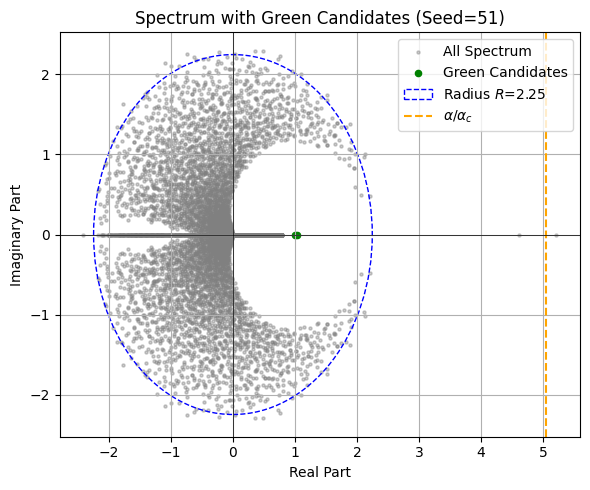

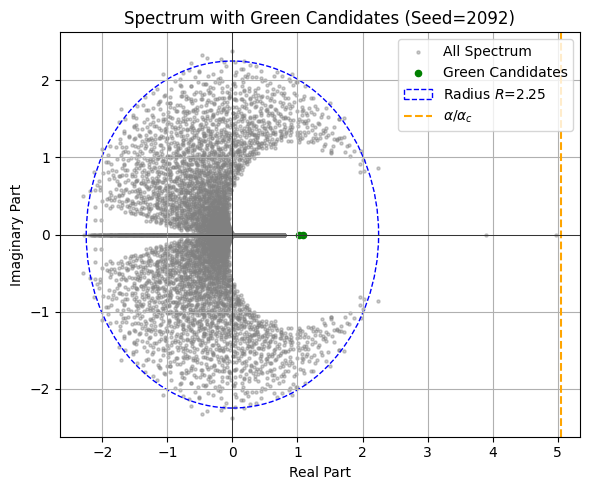

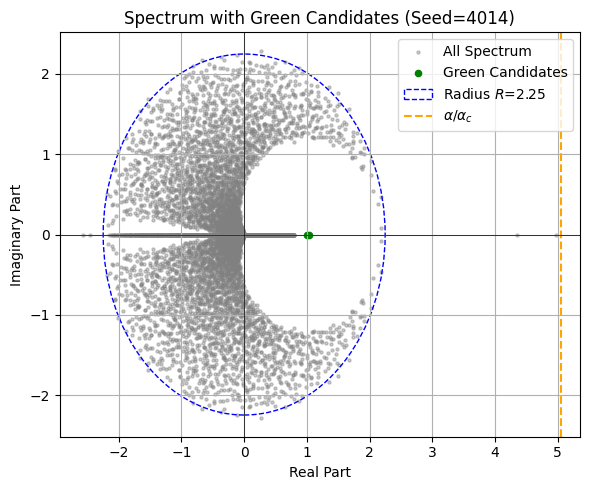

KeyboardInterrupt: 

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.stats import gaussian_kde

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 3, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
delta = 0.15


def run_and_plot(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p)
    X = torch.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    y_np = y.numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.numpy().astype(np.complex128)

    Re = eigvals_np.real
    Im = eigvals_np.imag
    Abs = np.abs(eigvals_np)
    real_axis_re = Re[np.abs(Im) < 1e-6]

    green_idx = []
    if len(real_axis_re) >= 100:
        kde = gaussian_kde(real_axis_re)
        grid = np.linspace(np.min(real_axis_re), np.max(real_axis_re), 1024)
        density = kde(grid)
        pileup_center = grid[np.argmax(density)]
        jump_thresh = pileup_center + delta

        jump_margin = 0.2

        green_mask = (
            (np.abs(Im) < 1e-6) &
            (Abs < R) &
            (Re > jump_thresh + jump_margin)
        )
        green_idx = np.where(green_mask)[0]

    # 绘图
    plt.figure(figsize=(6, 5))
    plt.scatter(Re, Im, s=5, color='gray', alpha=0.4, label='All Spectrum')
    if len(green_idx) > 0:
        plt.scatter(Re[green_idx], Im[green_idx], s=20, color='green', label='Green Candidates')

    circle = plt.Circle((0, 0), R, color='b', fill=False, linestyle='--', label=f'Radius $R$={R:.2f}')
    plt.gca().add_patch(circle)
    plt.axvline(x=thresh_ext, color='orange', linestyle='--', label=r'$\alpha/\alpha_c$')
    plt.axhline(0, color='k', linewidth=0.5)
    plt.axvline(0, color='k', linewidth=0.5)

    plt.title(f"Spectrum with Green Candidates (Seed={seed})")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ========== 改进版种子生成规则 ==========
# 示例：生成 20 个不连续且间隔较大的种子
np.random.seed(42)
base_seeds = np.arange(0, 10000, step=2000)  # 大间隔
noise = np.random.randint(0, 100, size=len(base_seeds))  # 引入小扰动
seeds = (base_seeds + noise).tolist()
print("使用的 seeds:", seeds)

# ========== 多轮运行 ==========
for seed in seeds:
    run_and_plot(seed)


